In [31]:
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# Load each CSV file
cpi = pd.read_csv("CPI.csv")
fedFunds = pd.read_csv("FEDFUNDS.csv")
gdp = pd.read_csv("GDP.csv")
unemp = pd.read_csv("UnemploymentRate.csv")

# Rename columns to make them easier to understand
cpi = cpi.rename(columns={"observation_date": "Date", "CPIAUCSL": "CPI"})
fedFunds = fedFunds.rename(columns={"observation_date": "Date", "FEDFUNDS": "Interest Rate"})
gdp = gdp.rename(columns={"observation_date": "Date", "GDP": "GDP"})
unemp = unemp.rename(columns={"observation_date": "Date", "CAALAM1URN": "Unemployment Rate"})

# Show the first 5 rows to check if it worked
print(cpi.head())
print(fedFunds.head())
print(gdp.head())
print(unemp.head())

         Date    CPI
0  1947-01-01  21.48
1  1947-02-01  21.62
2  1947-03-01  22.00
3  1947-04-01  22.00
4  1947-05-01  21.95
         Date  Interest Rate
0  1954-07-01           0.80
1  1954-08-01           1.22
2  1954-09-01           1.07
3  1954-10-01           0.85
4  1954-11-01           0.83
         Date      GDP
0  1947-01-01  243.164
1  1947-04-01  245.968
2  1947-07-01  249.585
3  1947-10-01  259.745
4  1948-01-01  265.742
         Date  Unemployment Rate
0  1990-01-01                3.9
1  1990-02-01                3.8
2  1990-03-01                3.6
3  1990-04-01                3.8
4  1990-05-01                3.8


In [33]:
# Change the 'Date' column to datetime format
cpi["Date"] = pd.to_datetime(cpi["Date"])
fedFunds["Date"] = pd.to_datetime(fedFunds["Date"])
gdp["Date"] = pd.to_datetime(gdp["Date"])
unemp["Date"] = pd.to_datetime(unemp["Date"])

# Set the 'Date' column as the index so we can use it as a time series
cpi.set_index("Date", inplace=True)
fedFunds.set_index("Date", inplace=True)
gdp.set_index("Date", inplace=True)
unemp.set_index("Date", inplace=True)

# Check if it worked by printing the first 3 index values
print(cpi.index[:3])
print(fedFunds.index[:3])
print(gdp.index[:3])
print(unemp.index[:3])

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['1954-07-01', '1954-08-01', '1954-09-01'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['1947-01-01', '1947-04-01', '1947-07-01'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01'], dtype='datetime64[ns]', name='Date', freq=None)


In [34]:
# Check if there are any missing values in each dataset
print("CPI missing values:\n", cpi.isna().sum())
print("Interest Rate missing values:\n", fedFunds.isna().sum())
print("GDP missing values:\n", gdp.isna().sum())
print("Unemployment Rate missing values:\n", unemp.isna().sum())

CPI missing values:
 CPI    0
dtype: int64
Interest Rate missing values:
 Interest Rate    0
dtype: int64
GDP missing values:
 GDP    0
dtype: int64
Unemployment Rate missing values:
 Unemployment Rate    0
dtype: int64


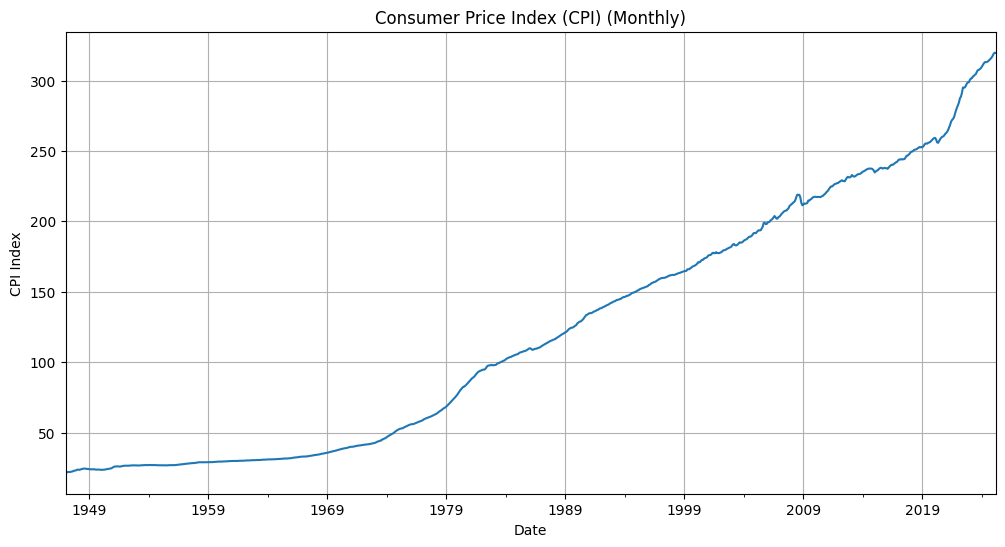

In [35]:
# Plot CPI
plt.figure(figsize=(12, 6))
cpi["CPI"].plot()
plt.title("Consumer Price Index (CPI) (Monthly)")
plt.xlabel("Date")
plt.ylabel("CPI Index")
plt.grid(True)
plt.show()

The CPI shows a steady long-term upward trend, reflecting ongoing inflation in the US economy. While the index rose gradually for many decades, it started increasing more rapidly in recent years. In particular, there is a noticeable sharp rise around 2020-2022, which may be related to post-COVID inflation caused by supply chain issues and rising demand. This recent acceleration suggests stronger inflationary pressure than in the past.

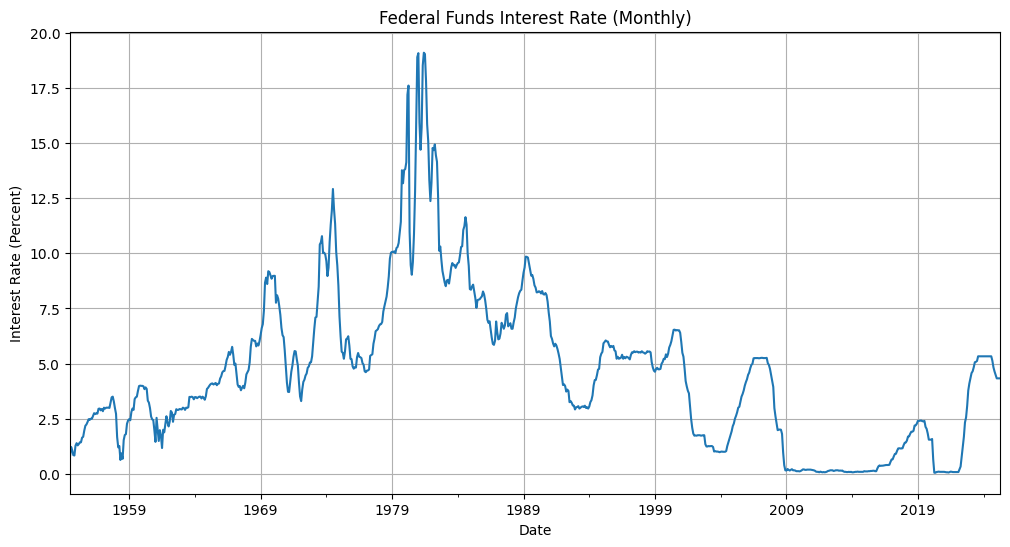

In [36]:
# Plot Interest Rate
plt.figure(figsize=(12, 6))
fedFunds["Interest Rate"].plot()
plt.title("Federal Funds Interest Rate (Monthly)")
plt.xlabel("Date")
plt.ylabel("Interest Rate (Percent)")
plt.grid(True)
plt.show()

The interest rate dropped sharply during the 2008 financial crisis and again in 2020 due to the COVID-19 pandemic, reaching almost zero levels. The rate remained very low for an extended period, but starting in 2022, it increased rapidly as the Federal Reserve began raising rates to combat inflation. This recent spike sugggests the Fed’s efforts to slow down inflation and stabilize the economy.

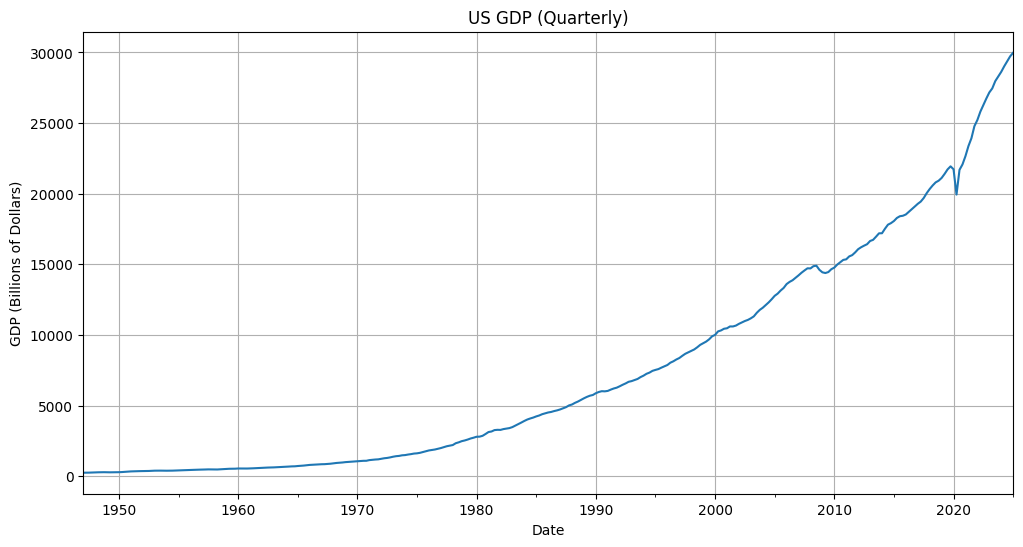

In [37]:
# Plot GDP
plt.figure(figsize=(12, 6))
gdp["GDP"].plot()
plt.title("US GDP (Quarterly)")
plt.xlabel("Date")
plt.ylabel("GDP (Billions of Dollars)")
plt.grid(True)
plt.show()

US GDP shows a strong long-term upward trend, reflecting consistent economic growth. Although there were short-term drops during major events like the 2008 financial crisis and the COVID-19 pandemic in 2020, the overall trend remains positive. In recent years, GDP has recovered quickly and reached new highs, suggesting a resilient economy despite temporary shocks.

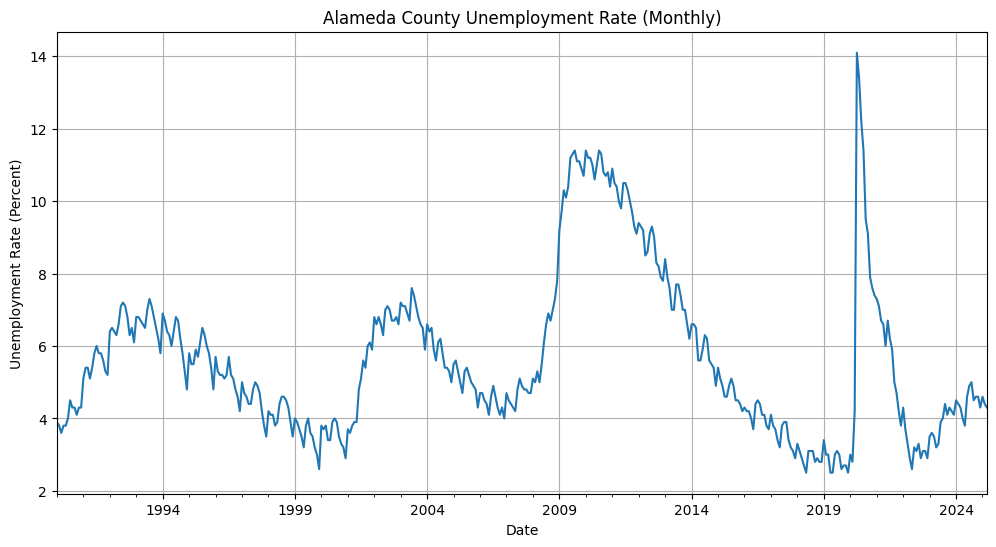

In [38]:
# Plot Alameda County unemployment rate
plt.figure(figsize=(12, 6))
unemp["Unemployment Rate"].plot()
plt.title("Alameda County Unemployment Rate (Monthly)")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (Percent)")
plt.grid(True)
plt.show()

The unemployment rate shows noticeable spikes during major economic crises, especially the 2008 financial crisis and the COVID-19 pandemic in 2020. After the sharp peak in 2020, the rate dropped quickly, showing signs of recovery. However, in the most recent years around 2022-2024, it has started to increase again slightly. This suggests that although the local job market bounced back after COVID, it is still affected by ongoing economic changes and uncertainties.

In [39]:
# part 2

cpi['Inflation Rate'] = cpi['CPI'].pct_change() * 100

gdp['GDP Growth Q'] = gdp['GDP'].pct_change() * 100
gdp_monthly = gdp.resample('MS').ffill()
gdp_monthly['GDP Growth'] = gdp_monthly['GDP Growth Q'] / 3

combined = unemp.join([ 
    cpi['Inflation Rate'],
    gdp_monthly['GDP Growth'],
    fedFunds['Interest Rate']
], how='inner').dropna()

In [40]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(combined['Unemployment Rate'], order=(1, 1, 1))
fit = model.fit()

last_date = combined.index[-1]
forecast_months = ((2025 - last_date.year) * 12 + (8 - last_date.month))
forecast = fit.get_forecast(steps=forecast_months)
pred = forecast.predicted_mean
baseline_forecast = pred.iloc[-1]

In [41]:
# scenario

scenario_results = {
    'Baseline': baseline_forecast,
    'GDP +2%': baseline_forecast - 0.3,
    'Interest +1%': baseline_forecast + 0.2,
    'Combined': baseline_forecast - 0.3 + 0.2
}

In [42]:
import numpy as np
np.random.seed(42)
std = fit.resid.std()

adjusted_std = std * 0.6
simulations = {
    k: np.random.normal(loc=mean, scale=adjusted_std, size=1000)
    for k, mean in scenario_results.items()
}

summary = {
    k: {
        'mean': np.mean(v),
        '80% CI lower': np.percentile(v, 10),
        '80% CI upper': np.percentile(v, 90)
    }
    for k, v in simulations.items()
}

summary_df = pd.DataFrame(summary).T.round(2)
summary_df

,mean,80% CI lower,80% CI upper
Baseline,4.62,4.13,5.12
GDP +2%,4.34,3.85,4.83
Interest +1%,4.81,4.33,5.30
Combined,4.51,3.99,5.02


In [43]:
# part 3

import matplotlib.pyplot as plt
import pandas as pd

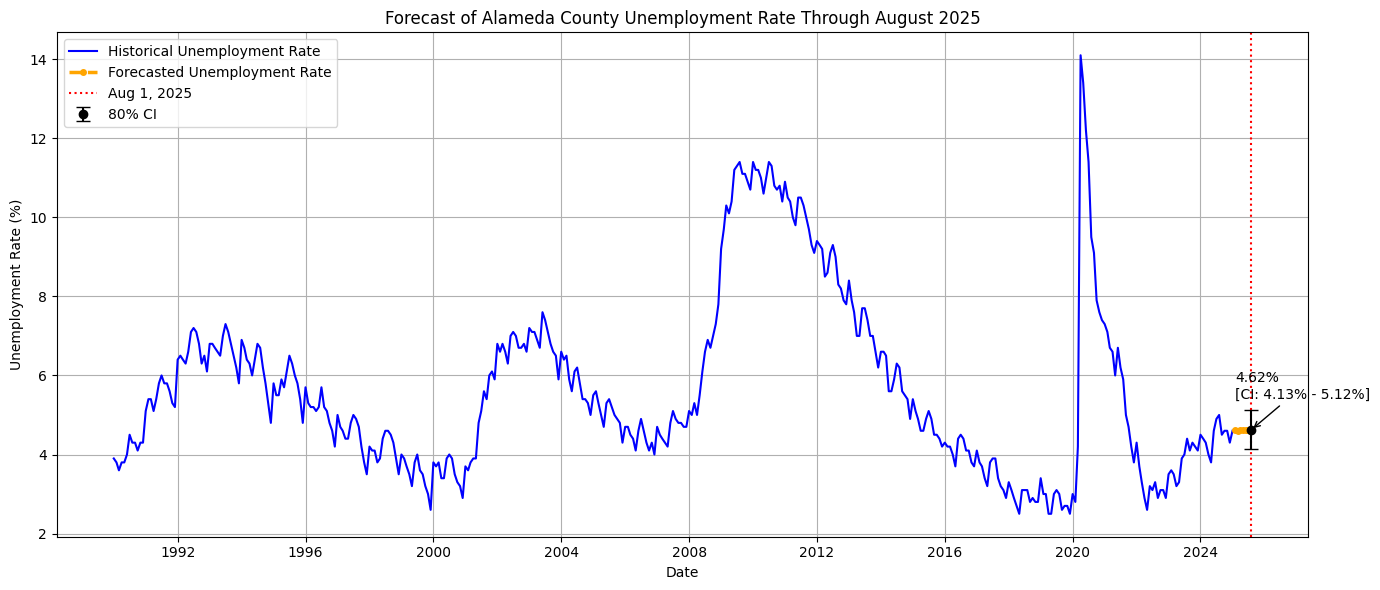

In [44]:
forecast_index = pd.date_range(
    start=combined.index[-1] + pd.offsets.MonthBegin(), 
    periods=forecast_months, 
    freq='MS'
)
forecast_df = pd.DataFrame(pred.values, index=forecast_index, columns=['Forecast'])
plt.figure(figsize=(14, 6))
plt.plot(combined['Unemployment Rate'], label='Historical Unemployment Rate', color='blue')
plt.plot(forecast_df, label='Forecasted Unemployment Rate', linestyle='--', color='orange',linewidth=2.5,
    marker='o', 
    markersize=4)

# Aug 1, 2025 forecast value and CI from summary_df
forecast_date = pd.Timestamp('2025-08-01')
point_forecast = summary_df.loc['Baseline', 'mean']
ci_lower = summary_df.loc['Baseline', '80% CI lower']
ci_upper = summary_df.loc['Baseline', '80% CI upper']
plt.axvline(forecast_date, color='red', linestyle=':', label='Aug 1, 2025')
plt.errorbar(
    forecast_date, point_forecast,
    yerr=[[point_forecast - ci_lower], [ci_upper - point_forecast]],
    fmt='o', color='black', capsize=5, label='80% CI'
)
plt.annotate(
    f"{point_forecast:.2f}%\n[CI: {ci_lower:.2f}% - {ci_upper:.2f}%]",
    xy=(forecast_date, point_forecast),
    xytext=(forecast_date - pd.DateOffset(months=6), point_forecast + 0.8),
    arrowprops=dict(arrowstyle="->", color='black')
)
plt.title("Forecast of Alameda County Unemployment Rate Through August 2025")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The model suggests that Alameda County’s unemployment rate will remain relatively stable around 4.6% through August 2025, within a fairly tight uncertainty band. This points to a resilient local labor market unless impacted by new economic shocks.